# CC covariance - split into components

### Import libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from numpy.linalg import inv, det, pinv
from matplotlib.colors import LogNorm

In [2]:
dir_home = os.getcwd()
dir_data = dir_home+'/../data/'

### Define functions and fiducial Planck cosmology

In [3]:
def Hzmodel(params, z):
    H0, Omegam, w0, wa = params
    return H0*np.sqrt(Omegam*(1+z)**3+(1-Omegam)*(1+z)**(3.*(1+w0+wa))*np.exp(-3.*wa*(z/(1+z))))

In [4]:
zz=np.arange(0., 2., 0.01)
Omegam_fid=0.308
errOmegam_fid=0.012
H0_fid=67.8
errH0_fid=0.9
w0_fid=-1
wa_fid=0

s=[H0_fid,Omegam_fid,w0_fid,wa_fid]

### Load data

In [5]:
os.chdir(dir_data)
filename = 'HzTable_MM_BC03.dat'
z, Hz, errHz, staterrHz, meterrHz = np.genfromtxt(filename, comments='#', usecols=(0,1,2,3,4), unpack=True, delimiter=',')
ref = np.genfromtxt(filename, comments='#', usecols=(3), unpack=True, dtype=str, delimiter=',')

filename = 'data_MM20.dat'
zmod, imf, slib, sps, spsooo = np.genfromtxt(filename, comments='#', usecols=(0,1,2,3,4), unpack=True)
os.chdir(dir_home)

### Estimate CC covariance components

In [6]:
cov_mat_diag = np.zeros((len(z), len(z)), dtype='float64') 
cov_mat_stat = np.zeros((len(z), len(z)), dtype='float64') 
cov_mat_met = np.zeros((len(z), len(z)), dtype='float64') 

for i in range(len(z)):
	cov_mat_diag[i,i] = errHz[i]**2
	cov_mat_stat[i,i] = staterrHz[i]**2
	cov_mat_met[i,i] = meterrHz[i]**2

imf_intp = np.interp(z, zmod, imf)/100
slib_intp = np.interp(z, zmod, slib)/100
sps_intp = np.interp(z, zmod, sps)/100
spsooo_intp = np.interp(z, zmod, spsooo)/100

cov_mat_imf = np.zeros((len(z), len(z)), dtype='float64')
cov_mat_slib = np.zeros((len(z), len(z)), dtype='float64')
cov_mat_sps = np.zeros((len(z), len(z)), dtype='float64')
cov_mat_spsooo = np.zeros((len(z), len(z)), dtype='float64')

for i in range(len(z)):
	for j in range(len(z)):
		cov_mat_imf[i,j] = Hz[i] * imf_intp[i] * Hz[j] * imf_intp[j]
		cov_mat_slib[i,j] = Hz[i] * slib_intp[i] * Hz[j] * slib_intp[j]
		cov_mat_sps[i,j] = Hz[i] * sps_intp[i] * Hz[j] * sps_intp[j]
		cov_mat_spsooo[i,j] = Hz[i] * spsooo_intp[i] * Hz[j] * spsooo_intp[j]
        

### Estimate full CC covariance matrix, and its determinant

In [7]:
cov_mat_sugg = cov_mat_spsooo+cov_mat_imf+cov_mat_diag
cov_mat_totooo = cov_mat_spsooo+cov_mat_imf+cov_mat_slib+cov_mat_diag
cov_mat_tot = cov_mat_sps+cov_mat_imf+cov_mat_slib+cov_mat_diag
cov_mat_nonstat = cov_mat_sps+cov_mat_imf+cov_mat_slib+cov_mat_met

cov_mat = cov_mat_sugg

inv_cov_mat = inv(cov_mat)

print("Determinant suggested total covariance matrix = {:.3e}".format(det(cov_mat_sugg)))
print("Determinant conservative total covariance matrix = {:.3e}".format(det(cov_mat_totooo)))
print("Determinant extra-conservative total covariance matrix = {:.3e}".format(det(cov_mat_tot)))
print("Determinant non-statistical total covariance matrix = {:.3e}".format(det(cov_mat_nonstat)))

Determinant suggested total covariance matrix = 4.560e+33
Determinant conservative total covariance matrix = 1.130e+34
Determinant extra-conservative total covariance matrix = 2.747e+34
Determinant non-statistical total covariance matrix = 4.109e+27


### Suggested combination: C_tot=C_stat+C_met+C_spsooo+C_IMF

Text(0.5, 1.0, 'Cov$_{imf}$')

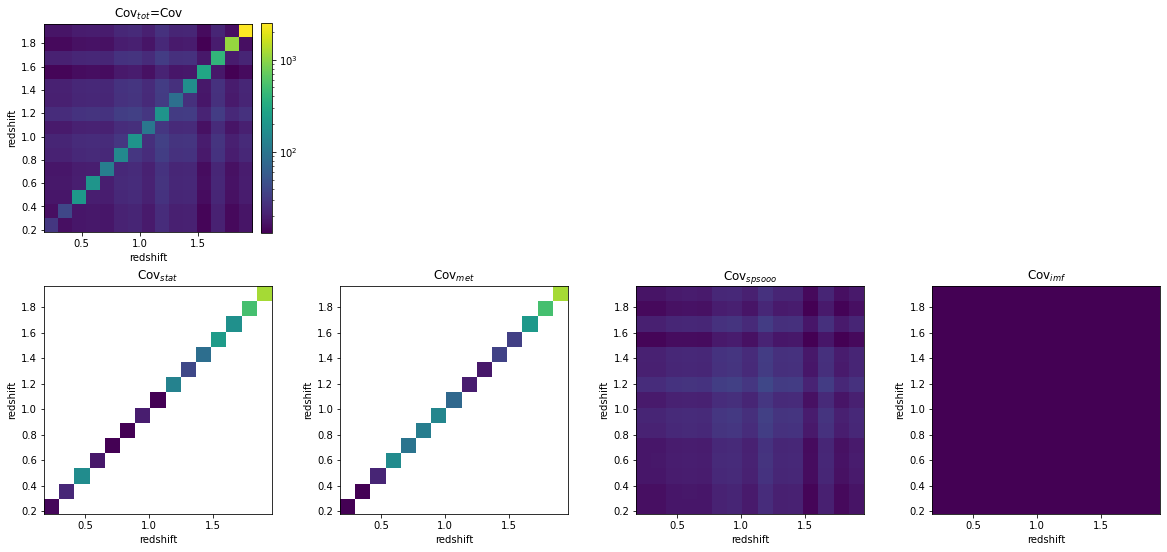

In [8]:
cov_mat = cov_mat_sugg

fig=plt.figure(figsize=(20,10))
gs=gridspec.GridSpec(2, 4)
gs.update(wspace=0.3, hspace=0.0)

ax1 = plt.subplot(gs[0])
cov = ax1.imshow(cov_mat, interpolation='none', cmap=plt.cm.viridis, extent=[z.min(), z.max(), z.min(), z.max()], origin='lower', norm=LogNorm(vmin=cov_mat.min(), vmax=cov_mat.max()))
fig.colorbar(cov,fraction=0.046, pad=0.04)
plt.xlabel(r'redshift')
plt.ylabel(r'redshift')
plt.title(r'Cov$_{tot}$=Cov')

ax2 = plt.subplot(gs[4])
cov = ax2.imshow(cov_mat_stat, interpolation='none', cmap=plt.cm.viridis, extent=[z.min(), z.max(), z.min(), z.max()], origin='lower', norm=LogNorm(vmin=cov_mat.min(),vmax=cov_mat.max()))
plt.xlabel(r'redshift')
plt.ylabel(r'redshift')
plt.title(r'Cov$_{stat}$')

ax3 = plt.subplot(gs[5])
cov = ax3.imshow(cov_mat_met, interpolation='none', cmap=plt.cm.viridis, extent=[z.min(), z.max(), z.min(), z.max()], origin='lower', norm=LogNorm(vmin=cov_mat.min(),vmax=cov_mat.max()))
plt.xlabel(r'redshift')
plt.ylabel(r'redshift')
plt.title(r'Cov$_{met}$')

ax4 = plt.subplot(gs[6])
cov = ax4.imshow(cov_mat_spsooo, interpolation='none', cmap=plt.cm.viridis, extent=[z.min(), z.max(), z.min(), z.max()], origin='lower', norm=LogNorm(vmin=cov_mat.min(),vmax=cov_mat.max()))
plt.xlabel(r'redshift')
plt.ylabel(r'redshift')
plt.title(r'Cov$_{spsooo}$')

ax5 = plt.subplot(gs[7])
cov = ax5.imshow(cov_mat_imf, interpolation='none', cmap=plt.cm.viridis, extent=[z.min(), z.max(), z.min(), z.max()], origin='lower', norm=LogNorm(vmin=cov_mat.min(),vmax=cov_mat.max()))
plt.xlabel(r'redshift')
plt.ylabel(r'redshift')
plt.title(r'Cov$_{imf}$')

### Conservative combination: C_tot=C_stat+C_met+C_spsooo+C_stlib+C_IMF

Text(0.5, 1.0, 'Cov$_{imf}$')

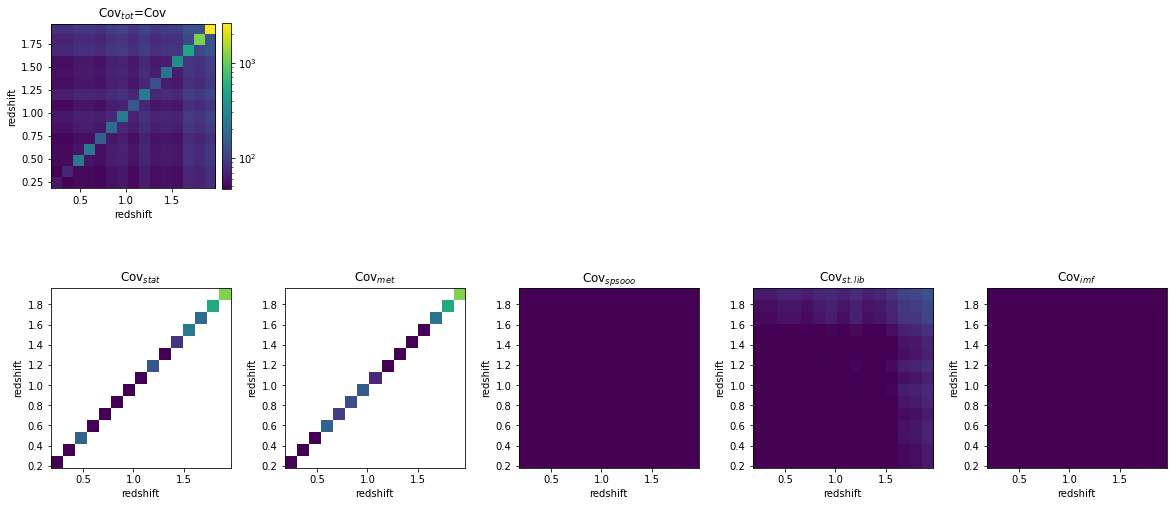

In [9]:
cov_mat = cov_mat_totooo

fig=plt.figure(figsize=(20,10))
gs=gridspec.GridSpec(2, 5)
gs.update(wspace=0.3, hspace=0.0)

ax1 = plt.subplot(gs[0])
cov = ax1.imshow(cov_mat, interpolation='none', cmap=plt.cm.viridis, extent=[z.min(), z.max(), z.min(), z.max()], origin='lower', norm=LogNorm(vmin=cov_mat.min(), vmax=cov_mat.max()))
fig.colorbar(cov,fraction=0.046, pad=0.04)
plt.xlabel(r'redshift')
plt.ylabel(r'redshift')
plt.title(r'Cov$_{tot}$=Cov')

ax2 = plt.subplot(gs[5])
cov = ax2.imshow(cov_mat_stat, interpolation='none', cmap=plt.cm.viridis, extent=[z.min(), z.max(), z.min(), z.max()], origin='lower', norm=LogNorm(vmin=cov_mat.min(),vmax=cov_mat.max()))
plt.xlabel(r'redshift')
plt.ylabel(r'redshift')
plt.title(r'Cov$_{stat}$')

ax3 = plt.subplot(gs[6])
cov = ax3.imshow(cov_mat_met, interpolation='none', cmap=plt.cm.viridis, extent=[z.min(), z.max(), z.min(), z.max()], origin='lower', norm=LogNorm(vmin=cov_mat.min(),vmax=cov_mat.max()))
plt.xlabel(r'redshift')
plt.ylabel(r'redshift')
plt.title(r'Cov$_{met}$')

ax4 = plt.subplot(gs[7])
cov = ax4.imshow(cov_mat_spsooo, interpolation='none', cmap=plt.cm.viridis, extent=[z.min(), z.max(), z.min(), z.max()], origin='lower', norm=LogNorm(vmin=cov_mat.min(),vmax=cov_mat.max()))
plt.xlabel(r'redshift')
plt.ylabel(r'redshift')
plt.title(r'Cov$_{spsooo}$')

ax5 = plt.subplot(gs[8])
cov = ax5.imshow(cov_mat_slib, interpolation='none', cmap=plt.cm.viridis, extent=[z.min(), z.max(), z.min(), z.max()], origin='lower', norm=LogNorm(vmin=cov_mat.min(),vmax=cov_mat.max()))
plt.xlabel(r'redshift')
plt.ylabel(r'redshift')
plt.title(r'Cov$_{st. lib}$')

ax6 = plt.subplot(gs[9])
cov = ax6.imshow(cov_mat_imf, interpolation='none', cmap=plt.cm.viridis, extent=[z.min(), z.max(), z.min(), z.max()], origin='lower', norm=LogNorm(vmin=cov_mat.min(),vmax=cov_mat.max()))
plt.xlabel(r'redshift')
plt.ylabel(r'redshift')
plt.title(r'Cov$_{imf}$')

### Extra-conservative combination: C_tot=C_stat+C_met+C_sps+C_stlib+C_IMF

Text(0.5, 1.0, 'Cov$_{imf}$')

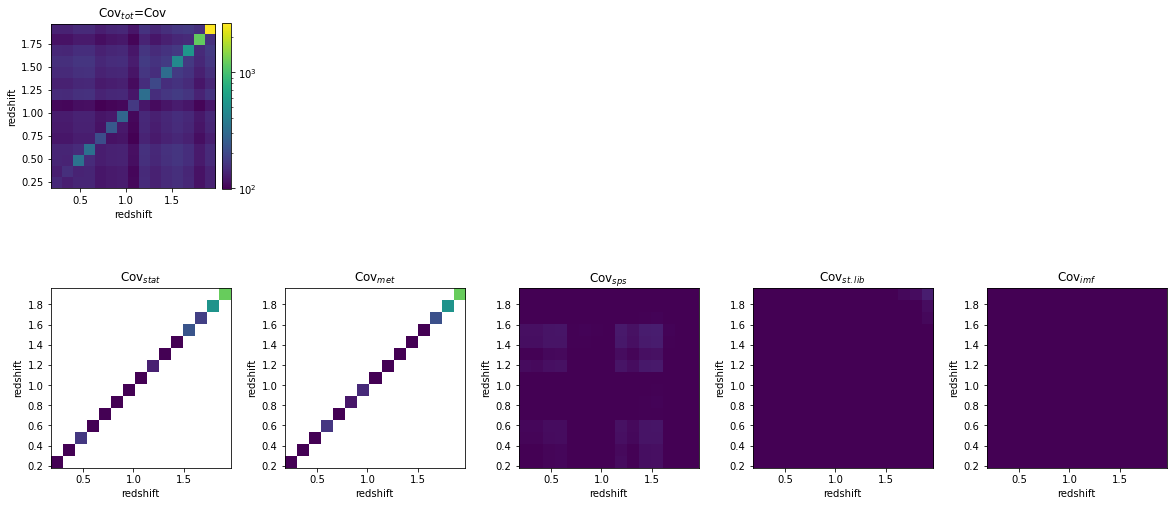

In [10]:
cov_mat = cov_mat_tot

fig=plt.figure(figsize=(20,10))
gs=gridspec.GridSpec(2, 5)
gs.update(wspace=0.3, hspace=0.0)

ax1 = plt.subplot(gs[0])
cov = ax1.imshow(cov_mat, interpolation='none', cmap=plt.cm.viridis, extent=[z.min(), z.max(), z.min(), z.max()], origin='lower', norm=LogNorm(vmin=cov_mat.min(), vmax=cov_mat.max()))
fig.colorbar(cov,fraction=0.046, pad=0.04)
plt.xlabel(r'redshift')
plt.ylabel(r'redshift')
plt.title(r'Cov$_{tot}$=Cov')

ax2 = plt.subplot(gs[5])
cov = ax2.imshow(cov_mat_stat, interpolation='none', cmap=plt.cm.viridis, extent=[z.min(), z.max(), z.min(), z.max()], origin='lower', norm=LogNorm(vmin=cov_mat.min(),vmax=cov_mat.max()))
plt.xlabel(r'redshift')
plt.ylabel(r'redshift')
plt.title(r'Cov$_{stat}$')

ax3 = plt.subplot(gs[6])
cov = ax3.imshow(cov_mat_met, interpolation='none', cmap=plt.cm.viridis, extent=[z.min(), z.max(), z.min(), z.max()], origin='lower', norm=LogNorm(vmin=cov_mat.min(),vmax=cov_mat.max()))
plt.xlabel(r'redshift')
plt.ylabel(r'redshift')
plt.title(r'Cov$_{met}$')

ax4 = plt.subplot(gs[7])
cov = ax4.imshow(cov_mat_sps, interpolation='none', cmap=plt.cm.viridis, extent=[z.min(), z.max(), z.min(), z.max()], origin='lower', norm=LogNorm(vmin=cov_mat.min(),vmax=cov_mat.max()))
plt.xlabel(r'redshift')
plt.ylabel(r'redshift')
plt.title(r'Cov$_{sps}$')

ax5 = plt.subplot(gs[8])
cov = ax5.imshow(cov_mat_slib, interpolation='none', cmap=plt.cm.viridis, extent=[z.min(), z.max(), z.min(), z.max()], origin='lower', norm=LogNorm(vmin=cov_mat.min(),vmax=cov_mat.max()))
plt.xlabel(r'redshift')
plt.ylabel(r'redshift')
plt.title(r'Cov$_{st. lib}$')

ax6 = plt.subplot(gs[9])
cov = ax6.imshow(cov_mat_imf, interpolation='none', cmap=plt.cm.viridis, extent=[z.min(), z.max(), z.min(), z.max()], origin='lower', norm=LogNorm(vmin=cov_mat.min(),vmax=cov_mat.max()))
plt.xlabel(r'redshift')
plt.ylabel(r'redshift')
plt.title(r'Cov$_{imf}$')